In [22]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
import pandas as pd
import utils

TS = 48

# samples = list(range(201, 211)) #[201, 202, 203]
samples = [221, 243, 232, 202, 204, 214, 205, 239, 248, 273, 282, 289]
data_train, df_date = utils.load_data('AusGrid_preprocess.csv', samples, TS)

State : [PV.gen, LD, PV.charge, PV.dischare, BS, GD, COST]
- PV.gen : PV generatoin power
- LD : Load consumption power
- PV.charge : Battery charging power
- PV.dischare : Battery discharging power
- BS : Battery status
- GD : Grid imort(+)/export(-) power
- COST : Cost for power

Action : [0, 1]
- 0 : discharging
- 1 : charging

Cost funciton(Reward)
- Self consumption : (PV - PV.charge + PV.dischare - GD) / PV
- Self sufficency : (PV - PV.charge + PV.dischare - GD) / LD

In [24]:
class Dueling_DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Dueling_DQN, self).__init__()
        self.num_actions = n_actions
        
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2_adv = nn.Linear(256, 128)
        self.layer2_val = nn.Linear(256, 128)
        
        self.layer3_adv = nn.Linear(128, n_actions)
        self.layer3_val = nn.Linear(128, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x_adv = F.relu(self.layer2_adv(x))
        x_val = F.relu(self.layer2_val(x))

        adv = self.layer3_adv(x_adv)
        val = self.layer3_val(x_val).expand(x_val.size(0), self.num_actions)

        # Q-value        
        x = val + adv - adv.mean(1).unsqueeze(1).expand(x_val.size(0), self.num_actions)
        return x

In [25]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TARGET_UPDATE = 10

n_observaons = 7
print(n_observaons)
n_actions = 2
policy_net = Dueling_DQN(n_observaons, n_actions).to(device)
target_net = Dueling_DQN(n_observaons, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

7


<All keys matched successfully>

In [26]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


In [27]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

In [28]:
optimizer = optim.AdamW(policy_net.parameters(), lr=1e-4, amsgrad=True)
memory = ReplayMemory(20000)

In [29]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 0

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
        
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()

    return loss.item()

    

In [ ]:
def Action(x):
    if x.item() == 1:
        return "Charge"
    elif x.item() == 0:
        return "Discharge"
    else:
        return "None"
    
loss_list = []
reward_list = []
all_sc_ss = []
num_episodes = len(data_train)

for i_episode in range(num_episodes):
    capacities = utils.cal_stds(data_train[i_episode%len(data_train)])
    for c in capacities:        
        epMemory = list()
        env = utils.ENV_BATT(data_train[i_episode%len(data_train)], max(0, c))
        state = env.reset()    
        state = torch.tensor(state).unsqueeze(0)

        loss_value = 0.0
        reward_value = 0.0

        total_export = 0.0
        total_import = 0.0
        total_pv = 0.0
        total_ld = 0.0
            
        for i in range(env.data_env.shape[0]):
            action = select_action(state)
            observation, reward, done=env.step(action.item())
            reward = torch.tensor([reward], device=device)
            reward_value += reward.squeeze(0).numpy()

            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            memory.push(torch.as_tensor(state), action, next_state, reward)
            state = next_state

            loss_value += optimize_model()

            total_export += state.squeeze(0).numpy()[5] if state.squeeze(0).numpy()[5] < 0 else 0
            total_import += state.squeeze(0).numpy()[5] if state.squeeze(0).numpy()[5] > 0 else 0
            total_pv += state.squeeze(0).numpy()[0]
            total_ld += state.squeeze(0).numpy()[1]
            
            if (i + 1) % TS == 0:
                loss_list.append(loss_value)
                loss_value = 0.0
                reward_list.append(reward_value)
                reward_value = 0.0
        
        target_net.load_state_dict(policy_net.state_dict())
        print(i_episode, 'Complete!!')

        sc = (total_pv + total_export)/total_pv
        ss = (total_ld - total_import)/total_ld
        all_sc_ss.append([sc, ss])
        print(i_episode, 'sc and ss', sc, ss)

/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_9189/219235915.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_9189/219235915.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


0 Complete!!
0 sc and ss 0.4609387859925765 0.12952950554806097
0 Complete!!
0 sc and ss 0.6864102452723566 0.19288977691340164
0 Complete!!
0 sc and ss 0.8369005941963757 0.23517942760021268
0 Complete!!
0 sc and ss 0.73064227665821 0.20531952507574966


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_9189/219235915.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_9189/219235915.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


1 Complete!!
1 sc and ss 0.6826324887101759 0.20925138793606027


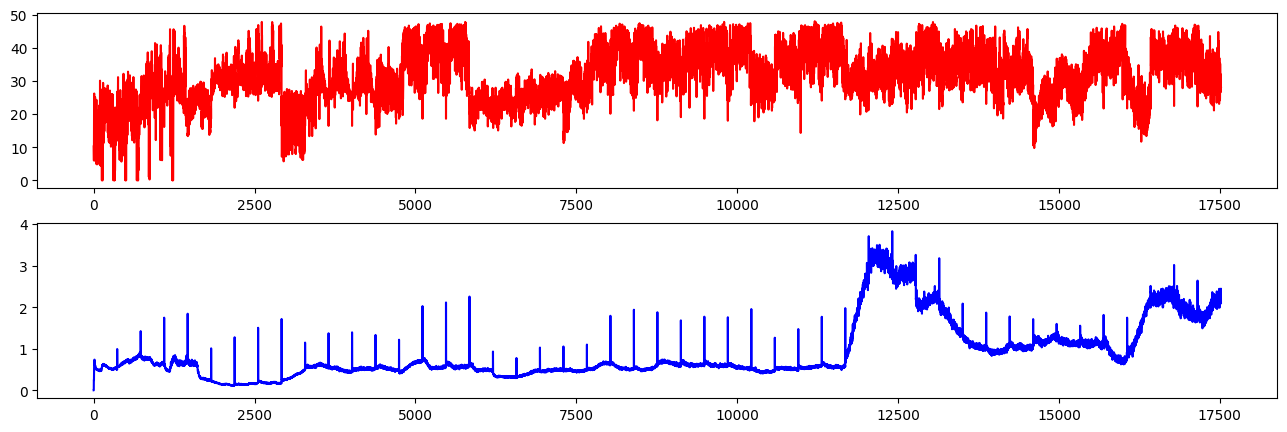

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,5))
axes[0].plot(np.array(reward_list), 'r')
# plt.ylim(0, 0.4)
axes[1].plot(np.array(loss_list), 'b')
# plt.ylim(0, 0.4)
plt.show() 

plt.plot(np.array(all_sc_ss)[:, 0])
plt.plot(np.array(all_sc_ss)[:, 1])
plt.show()

In [ ]:
data_test, df_date = utils.load_data('AusGrid_preprocess.csv', [1], TS)
data_test = data_test[0]
stds = utils.cal_stds(data_test)
print(stds)

(10, 15, 20, 25)


In [17]:
capacity = stds[3]
env = utils.ENV_BATT(data_test, capacity)
state = env.reset()    
state = torch.tensor(state).unsqueeze(0)

df_out = pd.DataFrame(columns=['PV', 'LD', 'PV.C', 'PV.D', 'BT', 'GD', 'COST', 'AC', 'RD'])

with torch.no_grad():
    for i in range(env.data_env.shape[0]): 
        # action = select_action(state)
        action = policy_net(state).max(1).indices.view(1, 1)        
        observation, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = observation.clone().detach().unsqueeze(0)
        st = next_state.numpy().squeeze(0)
        at = action.item()
        # print('Current x : ', t, 'Action :', at, ', y : ', next_state, 'reward :', reward.item())

        st = np.concatenate((st, np.array([at-1, reward.item()])))
        df_out.loc[i] = st
        state = next_state


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_9189/3793583023.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)


                      PV     LD     BT   AC     GD        RD
2012-07-01 00:30:00  0.0  0.855  2.500 -1.0  0.855  0.000000
2012-07-01 01:00:00  0.0  0.786  2.500  0.0  0.786  0.000000
2012-07-01 01:30:00  0.0  0.604  2.500  0.0  0.604  0.000000
2012-07-01 02:00:00  0.0  0.544  2.500 -1.0  0.544  0.000000
2012-07-01 02:30:00  0.0  0.597  2.500 -1.0  0.597  0.000000
...                  ...    ...    ...  ...    ...       ...
2012-07-05 22:30:00  0.0  0.414  4.337  0.0  0.414  0.620829
2012-07-05 23:00:00  0.0  0.932  4.337  0.0  0.932  0.622339
2012-07-05 23:30:00  0.0  0.070  4.337  0.0  0.070  0.623117
2012-07-06 00:00:00  0.0  0.094  4.337  0.0  0.094  0.623808
2012-07-06 00:30:00  0.0  0.056  4.337  0.0  0.056  0.625458

[241 rows x 6 columns]


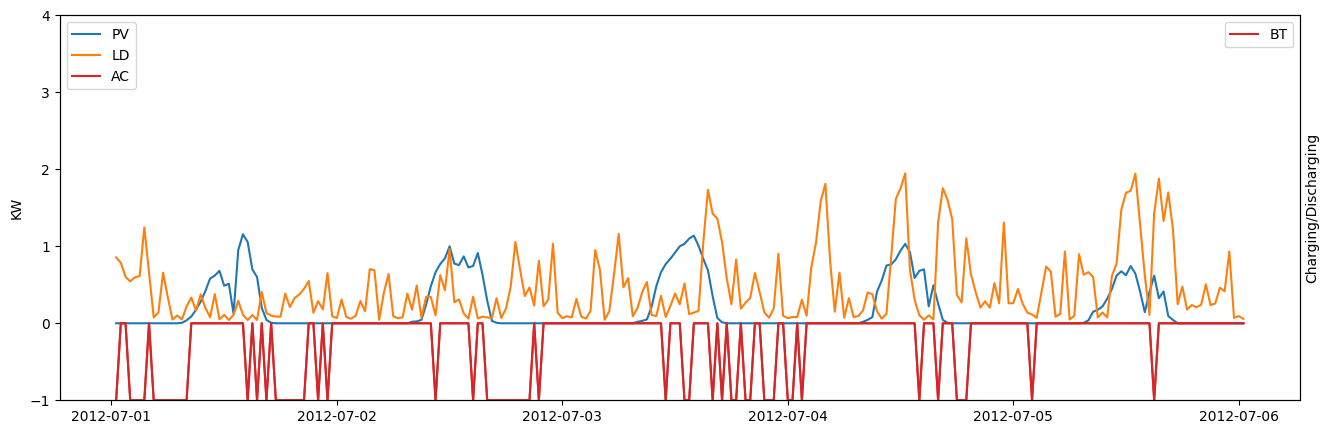

In [18]:
start_pos = 0
duration = TS*5
df_dis = df_out[['PV', 'LD', 'BT', 'AC', 'GD', 'RD']]
df_dis = df_dis.set_index(pd.Index(df_date.values))

pv =  df_dis['PV'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ld =  df_dis['LD'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
bt =  df_dis['BT'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ac =  df_dis['AC'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values

fig, ax1 = plt.subplots(figsize=(16, 5))
ax1.plot(df_date.values[start_pos:start_pos+duration+1], pv, label='PV', color='#1f77b4')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ld, label='LD', color='#ff7f0e')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='AC', color='#d62728')
ax1.legend(loc='upper left')
ax1.set_ylabel('KW')
ax1.set_ylim(-1, 4)

ax2 = ax1.twinx()
ax2.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='BT', color='#d62728')
ax2.legend(loc='upper right')
ax2.set_ylabel('Charging/Discharging')
ax2.set_yticks([])
ax2.set_ylim(-1, 4)

# ax = df_dis[['PV', 'LD', 'BT', 'AC']].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].plot(figsize=(16,5))
# ax.set_ylim(-1, 3)
# ax.set_ylabel('KW')
print(df_dis.loc[df_date.values[start_pos]:df_date.values[start_pos+duration]])
plt.show()

Text(0, 0.5, 'KW')

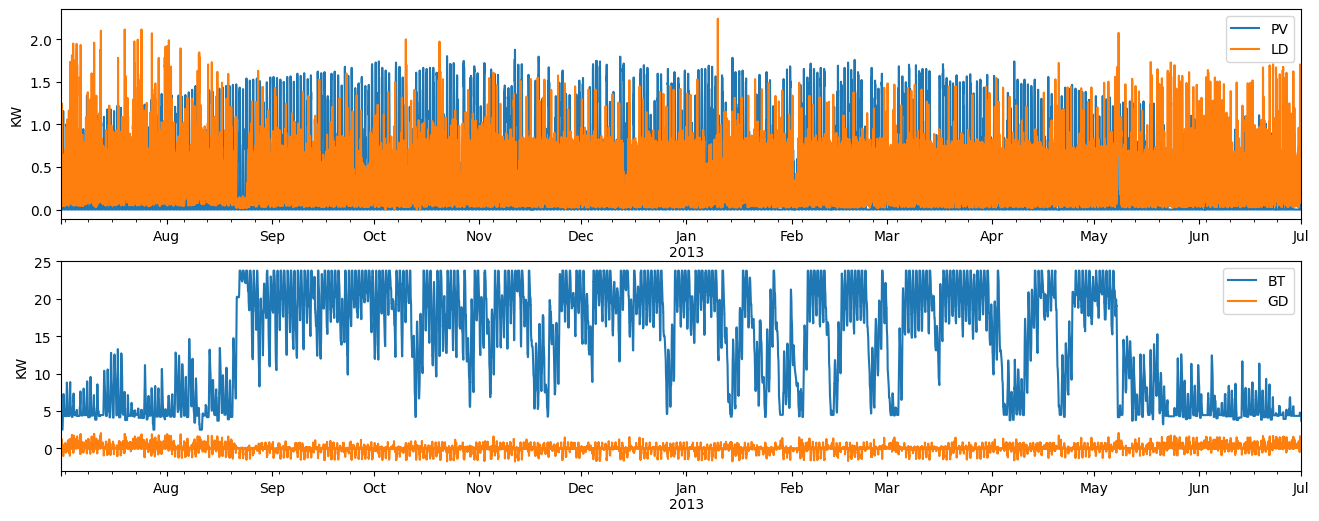

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
df_dis[['PV', 'LD']].plot(ax=axes[0])
df_dis[['BT', 'GD']].plot(ax=axes[1])

axes[0].set_ylabel('KW')
axes[1].set_ylabel('KW')

In [20]:
Egen = df_out['PV'].sum()
print(Egen, 'KW')
Eload = df_out['LD'].sum()
print(Eload, 'KW')
GDimport = df_out[df_out['GD'] > 0]['GD'].sum()
print(GDimport)
GDexport = df_out[df_out['GD'] < 0]['GD'].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Eload - GDimport)/Eload
print('SC :', SC)
print('SS :', SS)

5115.207006187178 KW
5279.884002253413 KW
1584.6490005189553
-1418.784999712021
SC : 0.7226339035749858
SS : 0.6998704896087415


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
 
max_len = len(df_out)

pv =  df_out['PV'].iloc[:].values
ld =  df_out['LD'].iloc[:].values
bt =  df_out['BT'].iloc[:].values
ac =  df_out['AC'].iloc[:].values
gd =  df_out['GD'].iloc[:].values
# ct =  df_out['COST'].iloc[:].values

def interactive_plot(window, start):    
    window *= 48
    start *= 48
    fig, ax1 = plt.subplots(figsize=(16, 5))    
    ax1.plot(df_date.values, pv, label='PV', color='#1f77b4')
    ax1.plot(df_date.values, ld, label='LD', color='#ff7f0e')
    ax1.plot(df_date.values, ac, label='AC', color='#d62728')
    ax1.plot(df_date.values, gd, label='GD', color='black')
    # ax1.plot(df_date.values, ct, label='COST', color='grey')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('KW')

    ax2 = ax1.twinx()
    ax2.plot(df_date.values, bt, label='BT', color='#2ca02c')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('KW')
    
    start = min(start, max_len-window)
    ax1.set_xlim(df_date.values[start], df_date.values[start+window-1])
    
    plt.show()

 
 
interact(interactive_plot, window=(1, 10, 1), start=(0, 365, 1))

interactive(children=(IntSlider(value=5, description='window', max=10, min=1), IntSlider(value=182, descriptio…

<function __main__.interactive_plot(window, start)>